In [1]:
import tensorflow as tf
import scipy
import numpy as np
import os.path
import helper
import project_tests as tests
from distutils.version import LooseVersion

In [2]:
helper.maybe_download_pretrained_vgg('./data')

  0%|          | 8.19K/997M [00:00<5:50:48, 47.4KB/s]

997MB [00:14, 66.6MB/s]                              


Extracting model...


In [3]:
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.2.1


In [4]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    model = tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)

    graph = tf.get_default_graph()

    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return image_input, keep_prob, layer3, layer4, layer7
tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [5]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    kernel_regularizer = tf.contrib.layers.l2_regularizer(0.001)
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()
    
    pool3_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)
    
    pool4_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)
    
    conv7_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, kernel_size=1, 
                                 padding='same', 
                                 kernel_initializer=kernel_initializer, 
                                 kernel_regularizer=kernel_regularizer)
    
    # make prediction of segmentation
    deconv7 = tf.layers.conv2d_transpose(conv7_1x1, num_classes, kernel_size=4, strides=2, padding='same',
                                         kernel_initializer=kernel_initializer, 
                                         kernel_regularizer=kernel_regularizer)
    
    fuse1 = tf.add(deconv7, pool4_1x1)
    deconv_fuse1 = tf.layers.conv2d_transpose(fuse1, num_classes, kernel_size=4, strides=2, padding='same',
                                              kernel_initializer=kernel_initializer,
                                              kernel_regularizer=kernel_regularizer)
    
    fuse2 = tf.add(deconv_fuse1, pool3_1x1)
    
    out = tf.layers.conv2d_transpose(fuse2, num_classes, kernel_size=16, strides=8, padding='same',
                                     kernel_initializer=kernel_initializer, 
                                     kernel_regularizer=kernel_regularizer)
    
    return out
tests.test_layers(layers)

Tests Passed


In [6]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_loss)
    
    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)

Tests Passed


In [7]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function 
    sess.run(tf.global_variables_initializer())
    losses_per_epoch = []
    for i in range(epochs):
        batch_count = 0
        for img, label, in get_batches_fn(batch_size):
            batch_count += 1
            losses = []
            _, loss = sess.run([train_op,cross_entropy_loss], feed_dict={input_image:img,
                              correct_label:label, keep_prob:0.5, learning_rate:0.0001})
            losses.append(loss)
        loss_per_epoch = sum(losses)/len(losses)
        losses_per_epoch.append(loss_per_epoch)
        print('epoch ', i+1, end='')
        print(' loss: ', loss_per_epoch)
        
    return losses_per_epoch
tests.test_train_nn(train_nn)

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


In [8]:
num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'
batch_size = 2
epochs = 20
tests.test_for_kitti_dataset(data_dir)

# OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
# You'll need a GPU with at least 10 teraFLOPS to train on.
#  https://www.cityscapes-dataset.com/

with tf.Session() as sess:
    # Path to vgg model
    vgg_path = os.path.join(data_dir, 'vgg')
    # Create function to get batches
    get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

    # TODO: Build NN using load_vgg, layers, and optimize function

    correct_label = tf.placeholder(tf.int32)
    learning_rate = tf.placeholder(tf.float32)

    image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
    nn_last_layer = layers(layer3_out, layer4_out, layer7_out, num_classes)
    logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, learning_rate, num_classes)


    # TODO: Train NN using the train_nn function
    losses_per_epoch = train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input, correct_label, keep_prob, learning_rate)

    # TODO: Save inference data using helper.save_inference_samples
    helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, image_input)

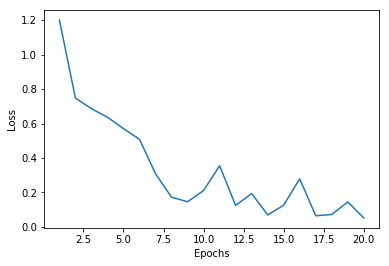

In [9]:
import matplotlib.pyplot as plt

x = np.linspace(1, epochs, epochs)
plt.plot(x, losses_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()